In [1]:
import torchtext
from torchtext.vocab import Vectors, GloVe
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from submission.models import *
from submission.helpers import *
from evaluation import *

In [2]:
# Our input $x$
TEXT = torchtext.data.Field()
    
# Our labels $y$
LABEL = torchtext.data.Field(sequential=False)


train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

# Build vocab
TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
(train, val, test), batch_size=11, device=-1)

# Build the vocabulary with word embeddings
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

# Multinomial NB

In [79]:
class MultinomialNB(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(MultinomialNB, self).__init__()
        self._TEXT = TEXT
        self._LABEL = LABEL
        self._text_vocab_len = len(self._TEXT.vocab)        
        self.n_positive = 0
        self.n_negative = 0
        # Smoothing para is 1 for all features
        self.p = torch.ones(self._text_vocab_len)
        self.q = torch.ones(self._text_vocab_len)
        self.r = None
        self.index_pos = LABEL.vocab.itos.index('positive')
        self.index_neg = LABEL.vocab.itos.index('negative')

    # could use EmbeddingsBag, but there's not a huge difference in
    # performance
    def get_features(self, batch):
        size_batch = batch.size()[0]
        features = torch.zeros(size_batch, self._text_vocab_len)
        for i in range(size_batch):
            for j in batch[i, :]:
                features[i, j.data[0]] += 1
        return features
        # return torch.Tensor(features)

    def train(self, train_iter):
        # There's probably a better way to do this
        num_iter = len(train_iter)
        train_iter = iter(train_iter)
        for i in range(num_iter):
            batch = next(train_iter)
            if i % 100 == 0:
                print(i)
            # Should be [N, num-features]
            features = self.get_features(torch.t(batch.text).contiguous())

            # Using broadcasting
            inds_pos = torch.nonzero(batch.label.data == self.index_pos)
            inds_neg = torch.nonzero(batch.label.data == self.index_neg)


            if inds_pos.size():
                self.n_positive += inds_pos.size()[0]
                self.p = torch.add(self.p, torch.sum(features[inds_pos, :], dim=0))                
            if inds_neg.size():
                self.n_negative += inds_neg.size()[0]
                self.q = torch.add(self.q, torch.sum(features[inds_neg, :], dim=0))

            # print(features)
            # print(inds_neg, inds_pos)
            # print(self.p.size(), torch.sum(features, dim=0).size())

        self.r = torch.log((self.p / self.p.sum()) / (self.q / self.q.sum()))
        
    def forward(self, batch):
        # for k in range(batch_text.size()[1]):
        features = self.get_features(batch)
        # Using broadcasting
        return torch.matmul(features, torch.squeeze(self.r)) + \
            np.log(self.n_positive / self.n_negative)

In [80]:
mnb = MultinomialNB(TEXT, LABEL)
mnb.train(train_iter)

0
100
200
300
400
500
600


In [81]:
evaluator = TextEvaluator(mnb)
evaluator.score(test_iter)

Iteration 0, predictions: [1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2]
Accuracy: 1501 1821 0.8242723778143877


# Log Reg

Iteration 0, loss: 1.098945
Iteration 100, loss: 0.701653
Iteration 200, loss: 0.722097
Iteration 300, loss: 0.489957
Iteration 400, loss: 0.523434
Iteration 500, loss: 0.583470
Iteration 600, loss: 0.558396
Iteration 700, loss: 0.655203
Iteration 800, loss: 0.791233
Iteration 900, loss: 0.366011


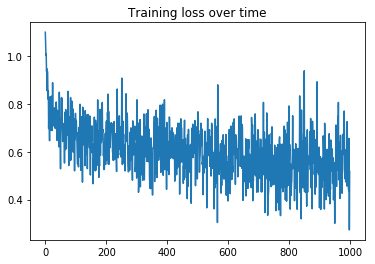

In [86]:
lr = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, lr)
trainer.train(train_iter)

In [87]:
evaluator = TextEvaluator(lr)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2]
Accuracy: 1308 1821 0.7182866556836903


# CBOW

Iteration 0, loss: 1.648201
Iteration 100, loss: 1.621424
Iteration 200, loss: 0.922567
Iteration 300, loss: 1.007872
Iteration 400, loss: 0.570381
Iteration 500, loss: 0.767750
Iteration 600, loss: 0.304812
Iteration 700, loss: 0.182766
Iteration 800, loss: 0.766858
Iteration 900, loss: 0.604174


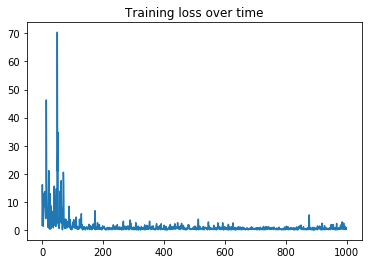

In [26]:
cbow = CBOW(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, cbow)
trainer.train(train_iter)

In [28]:
evaluator = TextEvaluator(cbow)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2]
Accuracy: 1392 1821 0.7644151565074135


# CNN

In [9]:
class CNN(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(CNN, self).__init__()
        
        N = TEXT.vocab.vectors.size()[0]
        D = TEXT.vocab.vectors.size()[1]
        C = len(LABEL.vocab)
        in_channels = 1
        out_channels = 100
        kernel_sizes = [2,3] 
        
        self.embeddings = nn.Embedding(N, D)
        self.embeddings.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad=True)
        
        # Linear layer
        self.linear = nn.Linear(TEXT.vocab.vectors.size()[1], len(LABEL.vocab))

        # List of convolutional layers
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels, out_channels, (K, D)) for K in kernel_sizes])

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(kernel_sizes)*out_channels, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, out_channels, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeddings(x)  # (N, W, D)

        x = x.unsqueeze(1)  # (N, in_channels, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, out_channels, W), ...]*len(kernel_sizes)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, out_channels), ...]*len(kernel_sizes)
        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = F.log_softmax(self.fc1(x), dim=1)  # (N, C)
        return logit

In [5]:
class CNN(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(CNN, self).__init__()
        
        N = TEXT.vocab.vectors.size()[0]
        D = TEXT.vocab.vectors.size()[1]
        C = len(LABEL.vocab)
        in_channels = 1
        out_channels = 100
        kernel_sizes = [2, 3, 4] 
        
        self.embeddings = nn.Embedding(N, D)
        self.embeddings.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad=True)
        
        # List of convolutional layers
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels,
                                               out_channels,
                                               (K, D),
                                               padding=(K-1, 0)) \
                                     for K in kernel_sizes])

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(kernel_sizes)*out_channels, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, out_channels, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeddings(x)  # (N, W, D)

        x = x.unsqueeze(1)  # (N, in_channels, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, out_channels, W)]*len(kernel_sizes)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, out_channels)]*len(kernel_sizes)
        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(kernet_sizes)*out_channels)
        logit = F.log_softmax(self.fc1(x), dim=1)  # (N, C)
        return logit


Iteration 0, loss: 1.229332
Iteration 100, loss: 0.617510
Iteration 200, loss: 0.556812
Iteration 300, loss: 0.412947
Iteration 400, loss: 0.494644
Iteration 500, loss: 0.472536
Iteration 600, loss: 0.479378
Iteration 700, loss: 0.110078
Iteration 800, loss: 0.166225
Iteration 900, loss: 0.361878
Iteration 1000, loss: 0.178175
Iteration 1100, loss: 0.367419
Iteration 1200, loss: 0.050419
Iteration 1300, loss: 0.544632
Iteration 1400, loss: 0.117423
Iteration 1500, loss: 0.165703
Iteration 1600, loss: 0.469320
Iteration 1700, loss: 0.082971
Iteration 1800, loss: 0.265977
Iteration 1900, loss: 0.163921
Iteration 2000, loss: 0.547286
Iteration 2100, loss: 0.952152
Iteration 2200, loss: 0.091068
Iteration 2300, loss: 0.488376
Iteration 2400, loss: 0.281847


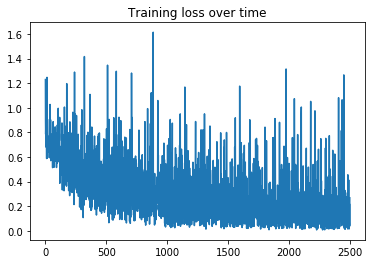

In [27]:
cnn = CNN(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, cnn)
trainer.train(train_iter, num_iter=2500)

In [29]:
evaluator = TextEvaluator(cnn)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2]
Iteration 100, predictions: [2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2]
Accuracy: 1449 1821 0.7957166392092258


In [88]:
class Ensemble(nn.Module):
    def __init__(self, TEST, LABEL):
        super(Ensemble, self).__init__()
        
        num_models = 2
        C = len(LABEL.vocab)
        self.linear = nn.Linear(num_models, C)

    def get_classes(self, probs, model):
        if len(probs.size()) == 1 or (len(probs.size()) == 2 \
                                      and probs.size()[1] == 1):
            signs = torch.sign(probs).type(torch.LongTensor)
            classes = (signs + 1) * (model.index_pos - model.index_neg) / 2 + \
                      model.index_neg
            # print(classes, probs)
        else:
            _, argmax = probs.max(1)
            classes = argmax.data
        return classes.view(1,len(classes))

    def forward(self, x):
        y1 = self.get_classes(mnb(x), mnb)
        y2 = self.get_classes(cnn(x), cnn)
        y3 = self.get_classes(lr(x), lr)
        y4 = self.get_classes(cbow(x), cbow)
        
        y = torch.t(torch.cat((y1, y2)).float())

        logit = F.log_softmax(self.linear(autograd.Variable(y)), dim=1)  # (N, C)
        return logit


Iteration 0, loss: 1.505540
Iteration 100, loss: 0.440472
Iteration 200, loss: 0.377348
Iteration 300, loss: 0.494561
Iteration 400, loss: 0.222336
Iteration 500, loss: 0.237212
Iteration 600, loss: 0.114122
Iteration 700, loss: 0.217128
Iteration 800, loss: 0.199956
Iteration 900, loss: 0.138437
Iteration 1000, loss: 0.073769
Iteration 1100, loss: 0.139576
Iteration 1200, loss: 0.118639
Iteration 1300, loss: 0.416430
Iteration 1400, loss: 0.118021
Iteration 1500, loss: 0.324109
Iteration 1600, loss: 0.051151
Iteration 1700, loss: 0.044518
Iteration 1800, loss: 0.151355
Iteration 1900, loss: 0.043212


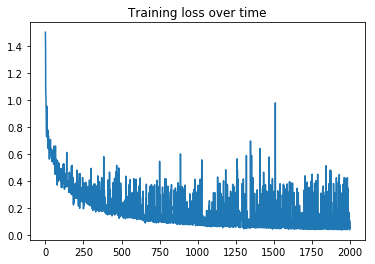

In [89]:
ensemble = Ensemble(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, ensemble)
trainer.train(train_iter, num_iter=2000)

In [90]:
evaluator = TextEvaluator(ensemble)
evaluator.score(test_iter)

Iteration 0, predictions: [1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2]
Accuracy: 1501 1821 0.8242723778143877
